<a href="https://colab.research.google.com/github/mahmud-nobe/Physics_Simulation_Tutorial/blob/main/system_of_stars/CS166_Final_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Necessary Packages and Functions 

In [ ]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
    """
    Write an animated GIF to file using matplotlib and ImageMagick.
    Inputs:
        draw_function (callable) The function to call, once per frame,
          to render to the current matplotlib figure. This function's call
          signature must be
            draw_function(current_frame_number, total_frame_count)
          The first frame is 0 and the last frame is total_frame_count-1.
        frames (int) The number of frames to generate.
        interval (float) The number of milliseconds to wait between frames
          in the animation. Set this to 40 for a fairly standard frame rate
          of 25fps (1 second / 40 (milliseconds per frame) = 25 frames per
          second).
        filename (str) The path to the file to write to. If none is provided,
          the animation will be written to a random filename, prefixed with
          "animate_" in the current directory. Default: None.
        verbose (bool) Whether to print the current frame number to the
          console as the animation is being created. This will clear other
          console output. Default: False.
        figure_params (dict) The keyword arguments to pass to matplotlib
          when creating a new figure for this animation. Use it to set the
          figure size and other figure properties. Default: None.
    Returns: A display object that will inject HTML for displaying the
      animated GIF into the notebook.
    """
    from matplotlib import pyplot, animation
    from IPython.display import HTML, display, clear_output
    import random

    if filename is None:
        filename = 'animate_%06i.gif' % random.randint(0, 999999)
    # Create figure
    if figure_params is None:
        figure_params = {}
    figure = pyplot.figure(**figure_params)
    # Wrap draw_function if we need to print to console
    if verbose:
        old_draw_function = draw_function
        def draw_function(current_frame_number, total_frame_count):
            old_draw_function(current_frame_number, total_frame_count)
            print('Processed frame', current_frame_number + 1, '/', total_frame_count)
            clear_output(wait=True)
            if current_frame_number + 1 == total_frame_count:
                print('Writing animation to file...')
                clear_output(wait=True)
    # Generate animation
    anim = animation.FuncAnimation(
        figure, draw_function, frames=frames, interval=interval,
        init_func=lambda: None, fargs=(frames,))
    #anim.save(filename, writer='imagemagick')
    # Close the animation figure so the last frame does not get displayed
    # in the notebook.
    #pyplot.close()
    # Return display object for the animated GIF
    #return display(HTML('<img src="' + filename + '">'))
    ret = display(HTML(anim.to_html5_video()))
    pyplot.close()
    return ret

## Empirical Simulation

In [ ]:
## Declaring the constants and units 

G = 6.67*10**(-11) # m**3/(kg s**2)
M_sun = 2*10**30 # kg
v_star = 3*10**3 # m/s
AU = 1.5*10**11 # m


In [ ]:
class Star:
    '''
    Class with all the properties of a star.
    x: x axis position
    y: y axis position
    vx: x component of velocity
    vy: y component of velocity
    '''
    def __init__(self, x, y, vx, vy, mass = 1, radius = 0.1):
        self.x = [x]
        self.y = [y]
        self.vx = [vx]
        self.vy = [vy]
        self.mass = mass
        self.radius = radius
        self.ax = []
        self.ay = []
        self.momentum_x = self.vx[-1]*self.mass
        self.momentum_y = self.vy[-1]*self.mass

In [ ]:
def truncnorm(mean, sigma, lower = 0):
    '''
    Function to generate a trancated normal distribution with mean = mean 
    and sigma and sigma which will only generate non-negative value
    '''
    myclip_a = lower
    myclip_b = 10**30
    my_mean = mean
    ## if sigma is 0, replace it with a low number to avoid division by 0
    my_std = max(sigma, 10**-30) 

    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return sts.truncnorm(a, b, loc = my_mean, scale = my_std)


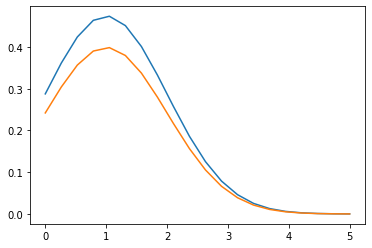

In [ ]:
x = np.linspace(0,5,20)
dist = truncnorm(mean = 1, sigma = 1)
plt.plot(x, dist.pdf(x))
plt.plot(x, sts.norm.pdf(x, 1, 1))
plt.show()

In [ ]:
class Cluster:
    '''
    System of group of stars, initial with the size of the grid
    '''
    def __init__(self, size):
        self.size = size
        self.stars = [] # list of all the current stars
        self.merged_stars = [] # list of stars who were merged
        self.n_merged_star = 0

    def initialize(self, density, mean_v, sigma_v = 0.01, explode = True, n_star = None):
        '''
        Initializing a random sample of stars. 
        explode: if True then generate a exploding system
        density: density of the stars in the given area
        mean_v: mean of the velocity distribution of all the stars
        sigma_v: sigma of the velocity distribution of all the stars
        '''
        self.binary = False
        
        self.density = density
        self.time = [0]
        
        if explode: # same outward velociy and normal initial distribution of position 
            self.area = np.pi*self.size**2
            self.n_star = int(round(self.density*self.area))
            
            # normal initial distribution of position
            star_x = sts.norm(0, self.size/2).rvs(size=self.n_star)
            star_y = sts.norm(0, self.size/2).rvs(size=self.n_star)

            self.center_of_mass_x = np.mean(star_x)
            self.center_of_mass_y = np.mean(star_y)

            for x,y in zip(star_x, star_y):
                d_x = x - self.center_of_mass_x
                d_y = y - self.center_of_mass_y
                dist = np.sqrt(d_x**2 + d_y**2)

                # generate velocity from the distribution
                v = truncnorm(mean_v, sigma_v).rvs()
                vx = v * d_x / dist
                vy = v * d_y / dist
                
                self.stars.append(Star(x, y, vx, vy))
        
        if not explode: # uniform initial distribution of position and velocity
            self.area = (2*self.size)**2
            self.n_star = int(round(self.density*self.area))
            
            # uniform initial distribution of position
            star_x = np.random.uniform(-self.size, self.size, size=self.n_star)
            star_y = np.random.uniform(-self.size, self.size, size=self.n_star)
        
            self.center_of_mass_x = np.mean(star_x)
            self.center_of_mass_y = np.mean(star_y)

            # uniform initial distribution of velocity
            star_vx = np.random.uniform(mean_v-2*sigma_v, mean_v+2*sigma_v, size=self.n_star)
            star_vy = np.random.uniform(mean_v-2*sigma_v, mean_v+2*sigma_v, size=self.n_star)
            
            for x,y, vx, vy in zip(star_x, star_y, star_vx, star_vy):
                self.stars.append(Star(x, y, vx, vy))

        # every star is of 1 M_sun
        self.total_mass = 1*self.n_star
        
        
        # calculate the acceleration at time = 0   
        for star in self.stars:
            star.ax.append(0)
            star.ay.append(0)
            for other_star in self.stars:
                d_x = other_star.x[-1] - star.x[-1]
                d_y = other_star.y[-1] - star.y[-1]
                dist = np.sqrt(d_x**2 + d_y**2)
                if (star != other_star):
                    acc = (G*other_star.mass*M_sun / 
                                (dist*AU)**2 )

                    # unit of ax, ay: m/s**2
                    star.ax[-1] += acc * d_x / dist
                    star.ay[-1] += acc * d_y / dist
        

    def initialize_binary(self, distance, mean_v, n_star = 2, sigma_v = 0.001, mass_ratio = 1):
        """
        Initializing a binary system.
        distance: distance between the two stars in AU
        mean_v: mean of the velocity distribution fo less massive star, star 1
        sigma_v: SD of the velocity distribution fo less massive star, star 1
        mass_ratio: mass_star0/ mass_star1. As star 0 is more massive, mass_ratio 
            is alwasws equal or more than 1.
        """
        self.binary = True
        self.n_star = n_star
        self.time = [0]
        
        
        # star 0 is the massive star, mean_v is the velocity of less massive star 1
        vel_1 = truncnorm(mean_v, sigma_v).rvs()
        vel_0 = truncnorm(mean_v, sigma_v).rvs() * np.sqrt(1/mass_ratio)
        
        # set the position only in x axis and velocity only in y axis
        self.stars.append(Star(0+distance/2, 0, 0, +vel_0))
        self.stars.append(Star(0-distance/2, 0, 0, -vel_1))
        
        # star 0 is the massive star
        self.stars[0].mass = mass_ratio 
        # radius will depend on the stars mass
        self.stars[0].radius = ((self.stars[0].mass * 4*np.pi*self.stars[0].radius**2)
                                /(4*np.pi))**0.5
        
        self.center_of_mass_x = 0
        self.center_of_mass_y = 0
        
        # star_1 has 1 M_sun
        self.total_mass = 1 + mass_ratio
        
        # distance between the stars
        self.dist = [distance]
        
        # calculate the acceleration at time = 0 
        for star in self.stars:
            star.ax.append(0)
            star.ay.append(0)
            for other_star in self.stars:
                d_x = other_star.x[-1] - star.x[-1]
                d_y = other_star.y[-1] - star.y[-1]
                dist = np.sqrt(d_x**2 + d_y**2)
                if (star != other_star):
                    acc = (G*other_star.mass*M_sun / 
                                ((dist*AU)**3) )

                    # unit of ax, ay: m/s**2
                    star.ax[-1] += acc * d_x
                    star.ay[-1] += acc * d_y
        
    def merge(self, star1, star2):
        # update the velocity to conserve momentum
        star1.vx[-1] = (star1.momentum_x + star2.momentum_x) / (star1.mass + star2.mass)
        star1.vy[-1] = (star1.momentum_y + star2.momentum_y) / (star1.mass + star2.mass)

        star1.mass += star2.mass
        star1.radius = ((4*np.pi*star1.radius**2 + 
                         4*np.pi*star2.radius**2)/(4*np.pi))**0.5
        
        self.stars.remove(star2)
        self.n_star -= 1
        self.merged_stars.append(star2)
        self.n_merged_star += 1

    def update(self):
        # select an appropriate timestep depending on the max_v and max_acc
        max_ax = max([star.ax[-1] for star in self.stars])
        max_ay = max([star.ay[-1] for star in self.stars])

        max_vx = max([star.vx[-1] for star in self.stars])
        max_vy = max([star.vy[-1] for star in self.stars])
        
        # see the details of chooing timestep in the paper 
        # 10**-15 are added to avoid division by zero
        # unit of timestep: s
        self.timestep = min( np.sqrt(AU/max(max_ax, max_ay, 10**(-15)))/10,
                            AU/(max(max_vx, max_vy, 10**(-15)) * v_star)/10 )
        
        timestep = self.timestep
        self.time.append(self.time[-1] + timestep)

        # Update the position first using leapfrog equation
        # unit of x,y: AU
        for star in self.stars:
            star.x.append(star.x[-1] + (star.vx[-1]*v_star) * timestep / AU + \
                            star.ax[-1]/2*(timestep)**2 / AU)
            star.y.append(star.y[-1] + (star.vy[-1]*v_star) * timestep / AU + \
                            star.ay[-1]/2*(timestep)**2 / AU)            

        
        # next, update the acceleration
        next_stars = self.stars.copy()    
 
        for star in next_stars:
            star.ax.append(0)
            star.ay.append(0)
            for other_star in self.stars:
                d_x = other_star.x[-1] - star.x[-1]
                d_y = other_star.y[-1] - star.y[-1]
                dist = np.sqrt(d_x**2 + d_y**2)
                if (star != other_star):
                    acc = (G*other_star.mass*M_sun / 
                                (dist*AU)**2 )

                    # unit of ax, ay: m/s**2
                    star.ax[-1] += acc * d_x / dist
                    star.ay[-1] += acc * d_y / dist
                    
        
        # Finally update the velocity using leapfrog method
        # unit of vx, vy: v_star
        for star in next_stars:
            star.vx.append(star.vx[-1] + (np.mean(star.ax[-2:])*timestep)/v_star)
            star.vy.append(star.vy[-1] + (np.mean(star.ay[-2:])*timestep)/v_star)


        self.stars = next_stars
                    
        # check if any two stars are closer than twice their radius, if yes, merge them
        for star in self.stars:
            for other_star in self.stars:
                d_x = other_star.x[-1] - star.x[-1]
                d_y = other_star.y[-1] - star.y[-1]
                dist = np.sqrt(d_x**2 + d_y**2)
                if (star != other_star and dist < star.radius*2):
                    self.merge(star, other_star)

        # update the position of center of mass
        star_mx = [star.mass*star.x[-1] for star in self.stars]
        star_my = [star.mass*star.y[-1] for star in self.stars]
        self.center_of_mass_x = np.sum(star_mx)/self.total_mass
        self.center_of_mass_y = np.sum(star_my)/self.total_mass
        
        # if it is binary star simulation, update the distance between stars
        if self.binary:
            if self.n_star > 1:
                d_x = self.stars[0].x[-1] - self.stars[1].x[-1]
                d_y = self.stars[0].y[-1] - self.stars[1].y[-1]
                dist = np.sqrt(d_x**2 + d_y**2)
                self.dist.append(dist)

    def display(self):
        '''
        Display the star system
        '''
        plt.figure(figsize=(8,8))

        x, y, r = [star.x[-1] for star in cluster.stars], [star.y[-1] for star in cluster.stars], [star.radius for star in cluster.stars]
        size = self.size*100 * np.array(r)**2
        plt.scatter(x, y, s = size)
        plt.title('Star clusters at t = '+str(np.round(cluster.time[-1], 2)))
        plt.show()

    def display_plot(self, parameter = ['xy']):
        """
        Display how the different paramters of the star cluster changes over time.
        """
        for param in parameter:
            if param == 'xy':
                for star in self.stars:
                    plt.plot(star.x, star.y)
                    plt.title('Position from the origin (0,0)')
                for star in self.merged_stars:
                    plt.plot(star.x, star.y)
                plt.xlabel('position in x (AU)')
                plt.ylabel('position in y (AU)')
                plt.show()

            elif param == 'vx':
                for star in self.stars:
                    plt.plot(self.time, star.vx)
                    plt.title('Velocity_x')
                for star in self.merged_stars:
                    n_data = len(star.x)
                    plt.plot(self.time[:n_data], star.vx)
                plt.xlabel('Time (s)')
                plt.ylabel('Velocity in x (v_star)')
                plt.show()

            elif param == 'vy':
                for star in self.stars:
                    plt.plot(self.time, star.vy)
                    plt.title('Velocity_y')
                for star in self.merged_stars:
                    n_data = len(star.y)
                    plt.plot(self.time[:n_data], star.vy)
                plt.xlabel('Time (s)')
                plt.ylabel('Velocity in y (v_star)')
                plt.show()
                
            elif param == 'v':
                for star in self.stars:
                    v = np.sqrt(np.array(star.vx)**2+np.array(star.vy)**2)
                    plt.plot(self.time, v)
                    plt.title('Velocity')
                for star in self.merged_stars:
                    n_data = len(star.x)
                    v = np.sqrt(np.array(star.vx)**2+np.array(star.vy)**2)
                    plt.plot(self.time[:n_data], v)
                plt.xlabel('Time (s)')
                plt.ylabel('Velocity (v_star)')
                plt.show()
            
            elif param == 'ax':
                for star in self.stars:
                    plt.plot(self.time[1:], star.ax[1:], 'o')
                    plt.title('Acceleration_x')
                for star in self.merged_stars:
                    n_data = len(star.x)
                    plt.plot(self.time[1:n_data], star.ax[1:], 'o')    
                plt.xlabel('Time')
                plt.ylabel('Acceleration in x (m/s^2)')
                plt.show()

            elif param == 'ay':
                for star in self.stars:
                    plt.plot(self.time[1:], star.ay[1:], 'o')
                    plt.title('Acceleration_y')
                for star in self.merged_stars:
                    n_data = len(star.x)
                    plt.plot(self.time[1:n_data], star.ay[1:], 'o')
                plt.xlabel('Time (s)')
                plt.ylabel('Acceleration in y (m/s^2)')
                plt.show()
                
            elif param == 'a':
                for star in self.stars:
                    a = np.sqrt(np.array(star.ax)**2+np.array(star.ay)**2)
                    plt.plot(self.time[1:], a[1:])
                    plt.title('Acceleration')
                for star in self.merged_stars:
                    n_data = len(star.x)
                    v = np.sqrt(np.array(star.ax)**2+np.array(star.ay)**2)
                    plt.plot(self.time[1:n_data], a[1:])
                plt.xlabel('Time (s)')
                plt.ylabel('Acceleration $(m/s^2)$')
                plt.show()
                
            elif param == 'dist':
                n_data = len(self.dist)
                plt.title('Distance Between Stars')
                plt.plot(self.time[:n_data], self.dist)
                plt.xlabel('Time (s)')
                plt.ylabel('Distance (AU)')
                plt.show()


## Same Mass Binary Star:
Distance, $d = 20 AU$

$m_{star 1}= 1 M_{sun}$, $m_{star 2}= 1 M_{sun}$


initial_vel = $\sqrt{\frac{G M_{sun} }{(20 AU)}} \frac{1}{v_{star}}$

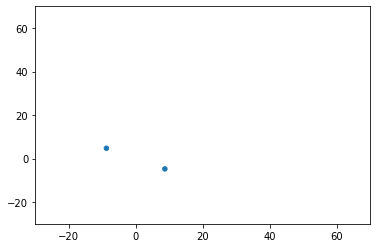

In [ ]:
cluster = Cluster(50)

dist = 20
vel = np.sqrt(0.5*G*M_sun/(dist*AU))/v_star

cluster.initialize_binary(distance = dist, mean_v=vel, sigma_v = vel/100, mass_ratio = 1)

fig = plt.figure()


ax = plt.axes(xlim=(-30, 70), ylim=(-30, 70))
x, y = [star.x[-1] for star in cluster.stars], [star.y[-1] for star in cluster.stars] 
scat = ax.scatter(x, y)

def animate(j):
    cluster.update()
    if (j % 25 == 0):
        x, y,r = [star.x[-1] for star in cluster.stars], [star.y[-1] for star in cluster.stars], [star.radius for star in cluster.stars]
        scat.set_offsets(np.c_[x,y])
        scat.set_sizes(200*np.array(r)**2*10)
    return scat,

anim = animation.FuncAnimation(fig, animate,
                               frames=500, 
                               interval=20)

HTML(anim.to_html5_video())


1.5717411906450662


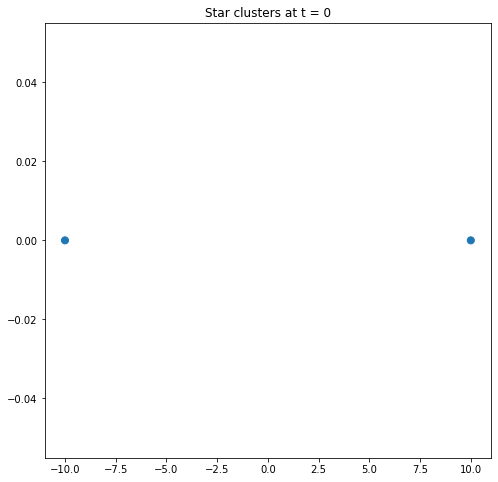

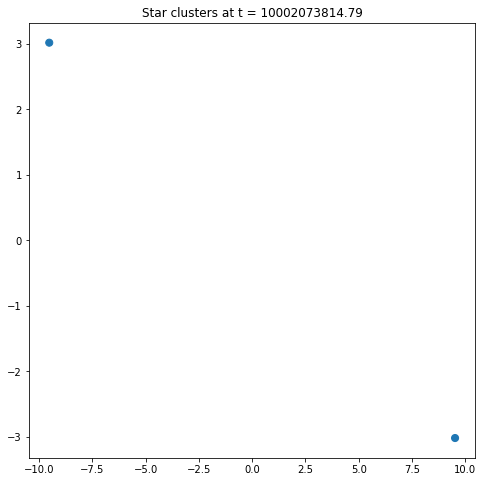

In [ ]:
cluster = Cluster(50)

dist = 20
vel = np.sqrt(0.5*G*M_sun/(dist*AU))/v_star

cluster.initialize_binary(distance = 20, mean_v=vel, sigma_v = vel/100, mass_ratio = 1)

print(vel)

cluster.display()

while(cluster.time[-1] < 10**10 and cluster.n_star > 1 and cluster.dist[-1] < 10**3):
    cluster.update()
    
cluster.display()



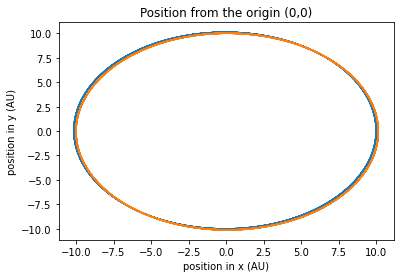

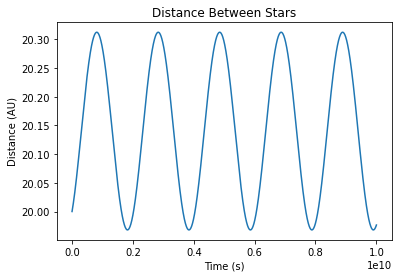

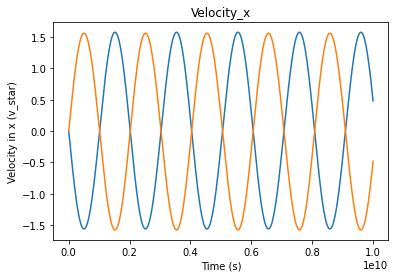

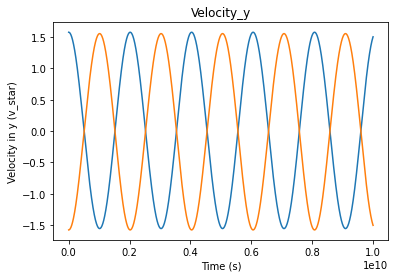

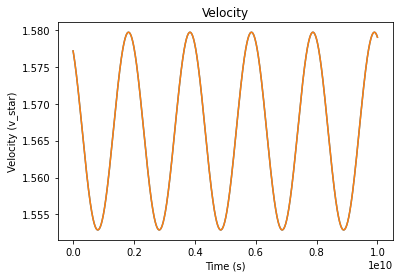

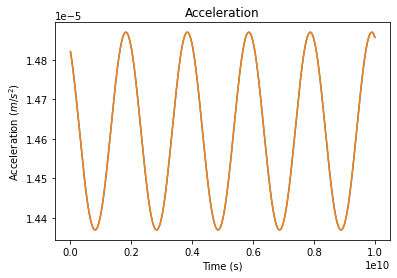

In [ ]:
cluster.display_plot(['xy', 'dist', 'vx','vy','v','a'])

## Different mass binary system
$m_{star 1}= 1 M_{sun}$, $m_{star 2}= 5 M_{sun}$

$d = 15 AU$

$v_{star 1}= 0$, $v_{star 2}= \sqrt{\frac{G \, 5\,M_{sun} }{(15 AU)}} \frac{1}{v_{star}}$

3.514520145318824


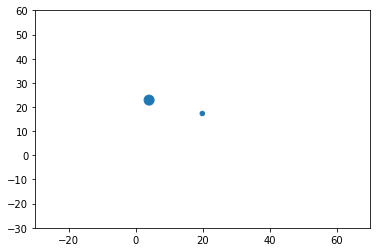

In [ ]:
cluster = Cluster(50)

dist = 20
vel = np.sqrt(0.5*G*5*M_sun/(dist*AU))/v_star

cluster.initialize_binary(distance = dist, mean_v=vel, sigma_v = vel/100, mass_ratio = 5)

print(vel)

fig = plt.figure()

ax = plt.axes(xlim=(-30, 70), ylim=(-30, 60))
x, y = [star.x[-1] for star in cluster.stars], [star.y[-1] for star in cluster.stars] 
scat = ax.scatter(x, y)

def animate(j):
    cluster.update()
    if (j % 25 == 0):
    #cluster.display()
    #print([(star.ax, star.ay) for star in cluster.stars])
        x, y,r = [star.x[-1] for star in cluster.stars], [star.y[-1] for star in cluster.stars], [star.radius for star in cluster.stars]
        scat.set_offsets(np.c_[x,y])
        scat.set_sizes(200*np.array(r)**2*10)
    return scat,

anim = animation.FuncAnimation(fig, animate,
                               frames=1000, 
                               interval=20)

HTML(anim.to_html5_video())


In [ ]:
cluster.display_plot()

3.514520145318824


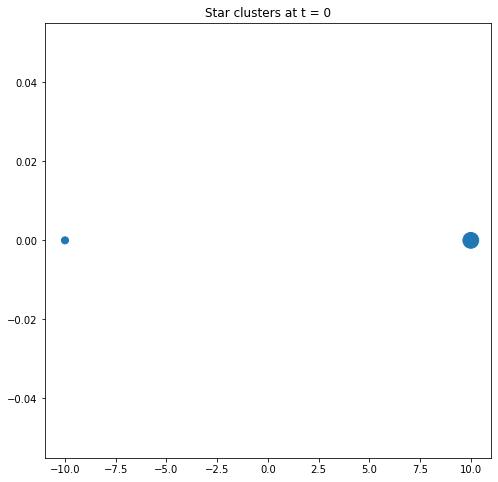

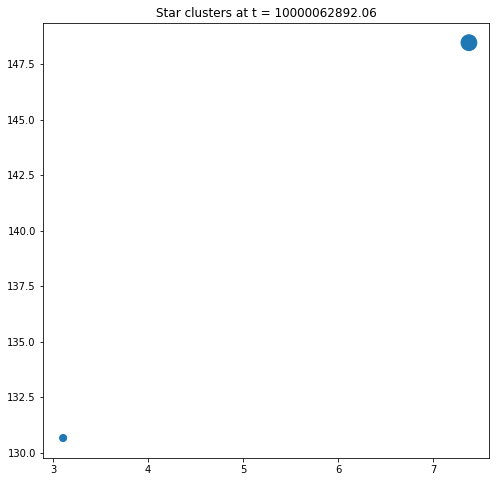

In [ ]:
cluster = Cluster(50)

dist = 20
vel = np.sqrt(0.5*G*5*M_sun/(dist*AU))/v_star

cluster.initialize_binary(distance = 20, mean_v=vel, sigma_v = vel/100, mass_ratio = 5)

print(vel)

cluster.display()

while(cluster.time[-1] < 10**10 and cluster.n_star > 1 and cluster.dist[-1] < 10**3):
    cluster.update()
    
cluster.display()



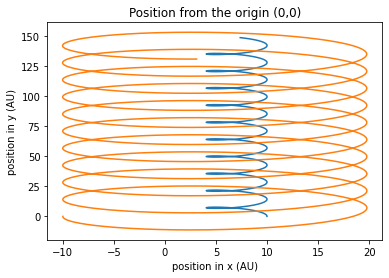

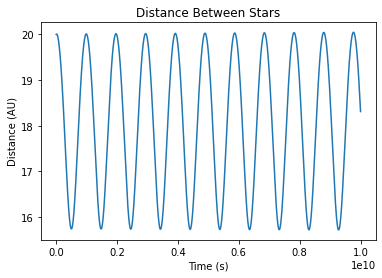

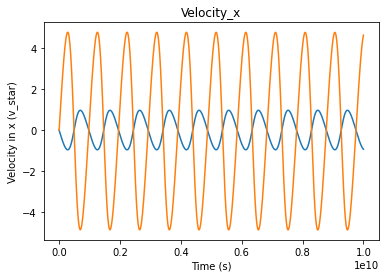

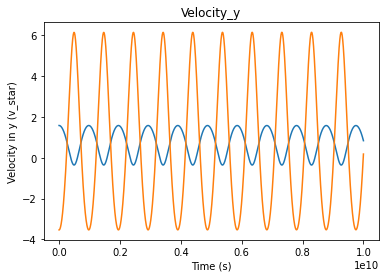

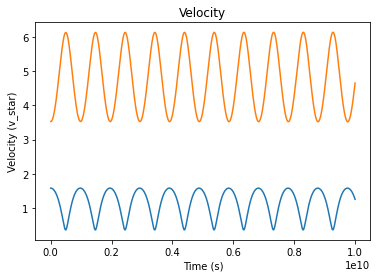

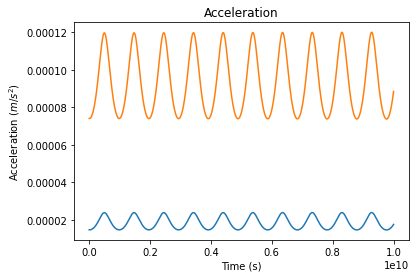

In [ ]:
cluster.display_plot(['xy', 'dist', 'vx','vy','v','a'])

## Exploding away from the center of mass

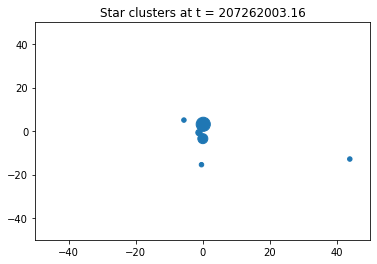

In [ ]:
cluster = Cluster(25)

mean_v = 2
sigma_v = mean_v/100

cluster.initialize(0.01, mean_v = mean_v, sigma_v=sigma_v)


fig = plt.figure()
ax = plt.axes(xlim=(-50, 50), ylim=(-50, 50))
x, y = [star.x[-1] for star in cluster.stars], [star.y[-1] for star in cluster.stars] 
scat = ax.scatter(x, y)



def animate(j):
    cluster.update()
    if (j % 25 == 0):
        x, y,r = [star.x[-1] for star in cluster.stars], [star.y[-1] for star in cluster.stars], [star.radius for star in cluster.stars]
        scat.set_offsets(np.c_[x,y])
        scat.set_sizes(200*np.array(r)**2*10)
        plt.title('Star clusters at t = '+str(np.round(cluster.time[-1], 2)))
    return scat,

anim = animation.FuncAnimation(fig, animate,
                            frames=500, 
                            interval=20)

HTML(anim.to_html5_video())


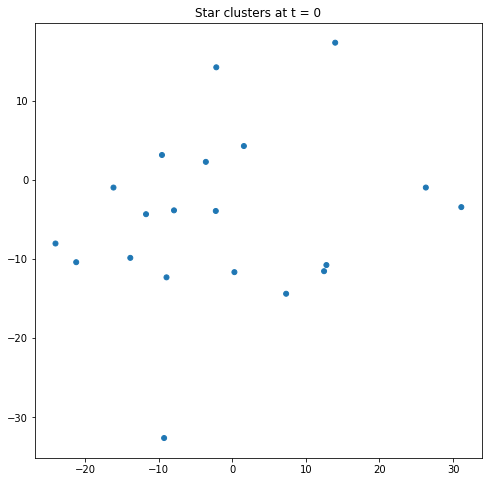

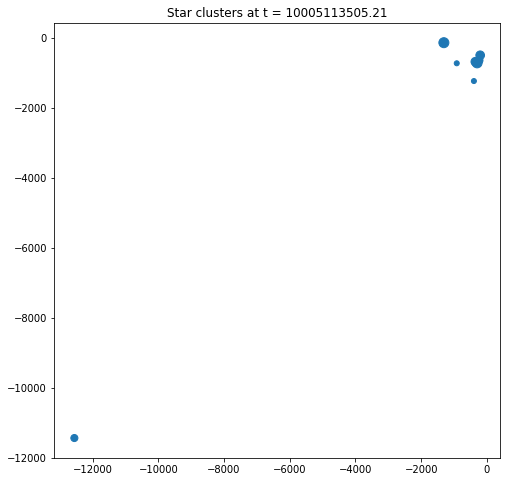

In [ ]:
cluster = Cluster(25)

mean_v = 2
sigma_v = mean_v/100

cluster.initialize(0.01, mean_v = mean_v, sigma_v=sigma_v)

cluster.display()

while(cluster.time[-1] < 10**10 and cluster.n_star > 1):
    cluster.update()
    
cluster.display()



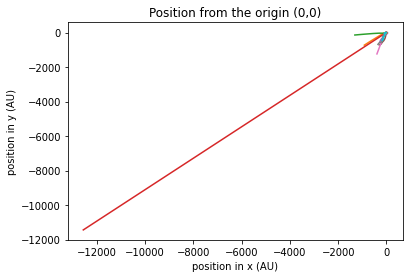

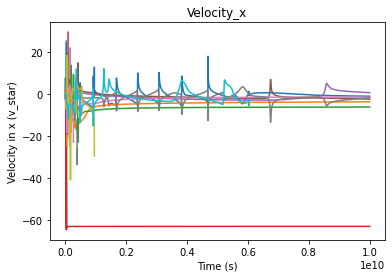

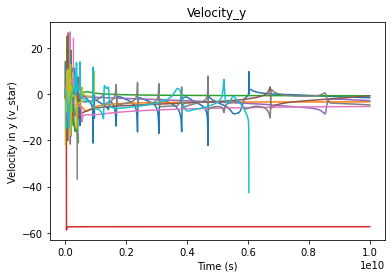

In [ ]:
cluster.display_plot(['xy', 'vx','vy'])

## Varying the initial velocity for exploding Model

In [ ]:
v_means = [10**i for i in np.linspace(-3,2, 11)]
np.log10(v_means), v_means

(array([-3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 [0.001,
  0.0031622776601683794,
  0.01,
  0.03162277660168379,
  0.1,
  0.31622776601683794,
  1.0,
  3.1622776601683795,
  10.0,
  31.622776601683793,
  100.0])

In [ ]:
cluster = Cluster(25)
def check_inside(cluster, check_radius = cluster.size*2):
    '''
    check the fraction of stars and fraction of total mass
    within the check_radius of the center of mass
    '''
    n_star_inside = 0
    mass_star_inside = 0
    
    for star in cluster.stars:
        d_x = star.x[-1] - cluster.center_of_mass_x
        d_y = star.y[-1] - cluster.center_of_mass_y
        dist = np.sqrt(d_x**2 + d_y**2)
        if dist < check_radius:
            mass_star_inside += star.mass
            n_star_inside += 1

    return n_star_inside/cluster.n_star, mass_star_inside/cluster.total_mass

In [ ]:
cluster = Cluster(25)
def check_radius(cluster):
    '''
    find the mean and median of the distances of the stars
    from the center of mass of the system
    '''
    d_x = [star.x[-1] - cluster.center_of_mass_x for star in cluster.stars]
    d_y = [star.y[-1] - cluster.center_of_mass_y for star in cluster.stars]
    
    dist = np.sqrt(np.array(d_x)**2 + np.array(d_y)**2)

    return np.mean(dist), np.median(dist)

In [ ]:
def confidence_interval(data):
    '''
    Returns the upper limit value of 
    95% confidence interval
    '''
    mean = np.mean(data)
    std = np.std(data)
    se = std/np.sqrt(len(data))
    upper95 = mean + 1.94*se
    return upper95

In [ ]:
v_means

[0.001,
 0.0031622776601683794,
 0.01,
 0.03162277660168379,
 0.1,
 0.31622776601683794,
 1.0,
 3.1622776601683795,
 10.0,
 31.622776601683793,
 100.0]

In [ ]:
n_trials = 20
mean_radius_mean = []
median_radius_mean = []
avg_n_merged_star_mean = []

mean_radius_upper95 = []
median_radius_upper95 = []
avg_n_merged_star_upper95 = []

for v in v_means:
    mean_radius = []
    median_radius = []
    avg_n_merged = []
    for i in range(n_trials):
        cluster = Cluster(size = 25)
        mean_v = v
        sigma_v = mean_v/100
        cluster.initialize(density = 0.01, mean_v = mean_v, sigma_v=sigma_v)

        while(cluster.time[-1] < 10**8 and cluster.n_star > 1):
            cluster.update()

        mean_r, median_r = check_radius(cluster)
        mean_radius.append(mean_r)
        median_radius.append(median_r)
        
        # stop running when all the stars merged or there is no star within 2*cluster size
        # otherwise run until time = 10**12
        while(cluster.time[-1] < 10**12 and check_inside(cluster)[0] != 0 and cluster.n_star > 1):
            cluster.update()
            
        avg_n_merged.append(cluster.n_merged_star/(cluster.n_merged_star+cluster.n_star))
        
        if ((i+1)%5 == 0):
            print(f'v = {v}: Trial: {i+1} complete...')

    mean_radius_mean.append(np.mean(mean_radius))
    median_radius_mean.append(np.mean(median_radius))
    avg_n_merged_star_mean.append(np.mean(avg_n_merged))

    mean_radius_upper95.append(confidence_interval(mean_radius))
    median_radius_upper95.append(confidence_interval(median_radius))
    avg_n_merged_star_upper95.append(confidence_interval(avg_n_merged))


v = 0.001: Trial: 5 complete...
v = 0.001: Trial: 10 complete...
v = 0.001: Trial: 15 complete...
v = 0.001: Trial: 20 complete...
v = 0.0031622776601683794: Trial: 5 complete...
v = 0.0031622776601683794: Trial: 10 complete...
v = 0.0031622776601683794: Trial: 15 complete...
v = 0.0031622776601683794: Trial: 20 complete...
v = 0.01: Trial: 5 complete...
v = 0.01: Trial: 10 complete...
v = 0.01: Trial: 15 complete...
v = 0.01: Trial: 20 complete...
v = 0.03162277660168379: Trial: 5 complete...
v = 0.03162277660168379: Trial: 10 complete...
v = 0.03162277660168379: Trial: 15 complete...
v = 0.03162277660168379: Trial: 20 complete...
v = 0.1: Trial: 5 complete...
v = 0.1: Trial: 10 complete...
v = 0.1: Trial: 15 complete...
v = 0.1: Trial: 20 complete...
v = 0.31622776601683794: Trial: 5 complete...
v = 0.31622776601683794: Trial: 10 complete...
v = 0.31622776601683794: Trial: 15 complete...
v = 0.31622776601683794: Trial: 20 complete...
v = 1.0: Trial: 5 complete...
v = 1.0: Trial: 10 c

In [ ]:
mean_radius_error = np.array(mean_radius_upper95) - np.array(mean_radius_mean)
median_radius_error = np.array(median_radius_upper95) - np.array(median_radius_mean)

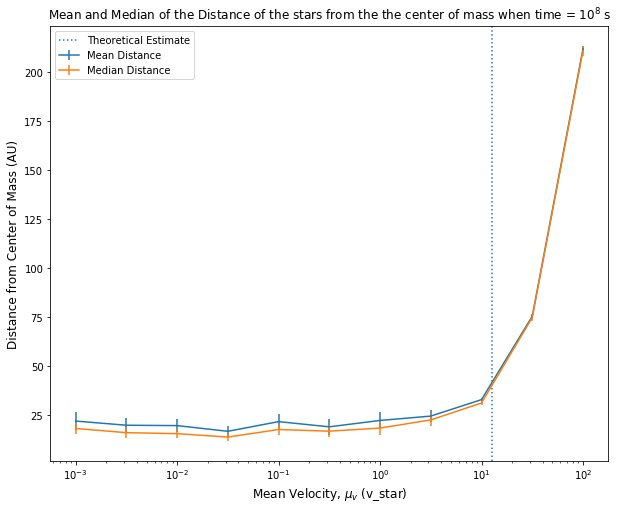

In [ ]:
plt.figure(figsize=(10,8))
plt.errorbar(v_means, mean_radius_mean, mean_radius_error, label = 'Mean Distance')
plt.errorbar(v_means, median_radius_mean, median_radius_error, label = 'Median Distance')
plt.xscale('log')
plt.xlabel('Mean Velocity, $\mu_v$ (v_star)', fontsize=12)
plt.title('Mean and Median of the Distance of the stars from the the center of mass when time = $10^{8}$ s', fontsize=12)
plt.ylabel('Distance from Center of Mass (AU)', fontsize=12)
theoritical_v = np.sqrt(2*G*cluster.total_mass*M_sun/(cluster.size*AU))/v_star
plt.axvline(theoritical_v, linestyle = ":", label = 'Theoretical Estimate')
plt.legend()
plt.show()

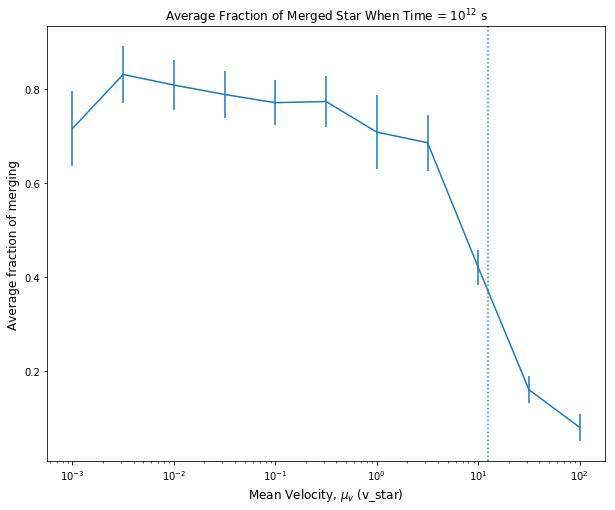

In [ ]:
avg_n_merge_error = np.array(avg_n_merged_star_upper95) - np.array(avg_n_merged_star_mean)

plt.figure(figsize=(10,8))
plt.errorbar(v_means, avg_n_merged_star_mean, avg_n_merge_error)
plt.xlabel('Mean Velocity, $\mu_v$ (v_star)', fontsize=12)
plt.ylabel('Average fraction of merging', fontsize=12)
plt.title('Average Fraction of Merged Star When Time = $10^{12}$ s', fontsize=12)
theoritical_v = np.sqrt(2*G*cluster.total_mass*M_sun/(cluster.size*AU))/v_star
plt.axvline(theoritical_v, linestyle = ":", label = 'Theoretical Estimate')
plt.xscale('log')
plt.show()

In [ ]:
np.sqrt(2*G*20*M_sun/(25*AU))/v_star

12.57392952516053

## Varying the velocity for Binary Star System 

Distance = 20 AU

Mass1 = Mass2 = 1 M_sun

In [ ]:
v_means = np.linspace(0, 5, 11)
v_means

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [ ]:
n_trials = 20
dist_mean = []
dist_upper95 = []

for v in v_means:
    dist_list = []

    for i in range(n_trials):
        cluster = Cluster(size = 25)
        dist = 20
        mean_v = v
        sigma_v = mean_v/100
        cluster.initialize_binary(distance = dist, mean_v=mean_v, sigma_v = sigma_v, mass_ratio = 1)
        
        # stop running when all the stars merged or distance between the stars are 200 AU
        # otherwise run until time = 10**10 s
        while(cluster.time[-1] < 10**10 and cluster.n_star > 1 and cluster.dist[-1] < 200):
            cluster.update()
        
        if cluster.n_star == 1: 
            dist_list.append(0)
        else:
            dist_list.append(cluster.dist[-1])
        
        if ((i+1)%5 == 0):
            print(f'v = {v}: Trial: {i+1} complete...')

    dist_mean.append(np.mean(dist_list))
    dist_upper95.append(confidence_interval(dist_list))
    


v = 0.0: Trial: 5 complete...
v = 0.0: Trial: 10 complete...
v = 0.0: Trial: 15 complete...
v = 0.0: Trial: 20 complete...
v = 0.5: Trial: 5 complete...
v = 0.5: Trial: 10 complete...
v = 0.5: Trial: 15 complete...
v = 0.5: Trial: 20 complete...
v = 1.0: Trial: 5 complete...
v = 1.0: Trial: 10 complete...
v = 1.0: Trial: 15 complete...
v = 1.0: Trial: 20 complete...
v = 1.5: Trial: 5 complete...
v = 1.5: Trial: 10 complete...
v = 1.5: Trial: 15 complete...
v = 1.5: Trial: 20 complete...
v = 2.0: Trial: 5 complete...
v = 2.0: Trial: 10 complete...
v = 2.0: Trial: 15 complete...
v = 2.0: Trial: 20 complete...
v = 2.5: Trial: 5 complete...
v = 2.5: Trial: 10 complete...
v = 2.5: Trial: 15 complete...
v = 2.5: Trial: 20 complete...
v = 3.0: Trial: 5 complete...
v = 3.0: Trial: 10 complete...
v = 3.0: Trial: 15 complete...
v = 3.0: Trial: 20 complete...
v = 3.5: Trial: 5 complete...
v = 3.5: Trial: 10 complete...
v = 3.5: Trial: 15 complete...
v = 3.5: Trial: 20 complete...
v = 4.0: Trial: 

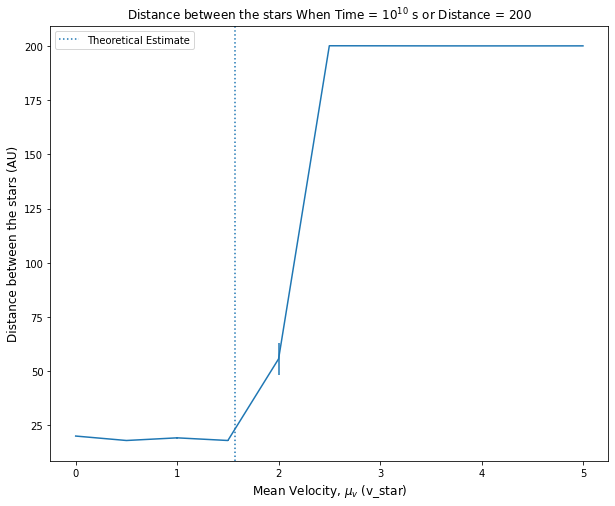

In [ ]:
dist_error = np.array(dist_upper95) - np.array(dist_mean)

plt.figure(figsize=(10,8))
plt.errorbar(v_means, dist_mean, dist_error)
plt.xlabel('Mean Velocity, $\mu_v$ (v_star)', fontsize=12)
plt.ylabel('Distance between the stars (AU)', fontsize=12)
plt.title('Distance between the stars When Time = $10^{10}$ s or Distance = 200', fontsize=12)
distance = 20
theoritical_v = np.sqrt(G*M_sun/(2*distance*AU))/v_star
plt.axvline(theoritical_v, linestyle = ":", label = 'Theoretical Estimate')
plt.legend()
plt.show()

In [ ]:
np.sqrt(G*M_sun/(2*distance*AU))/v_star

1.5717411906450662